[*********************100%%**********************]  1 of 1 completed


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


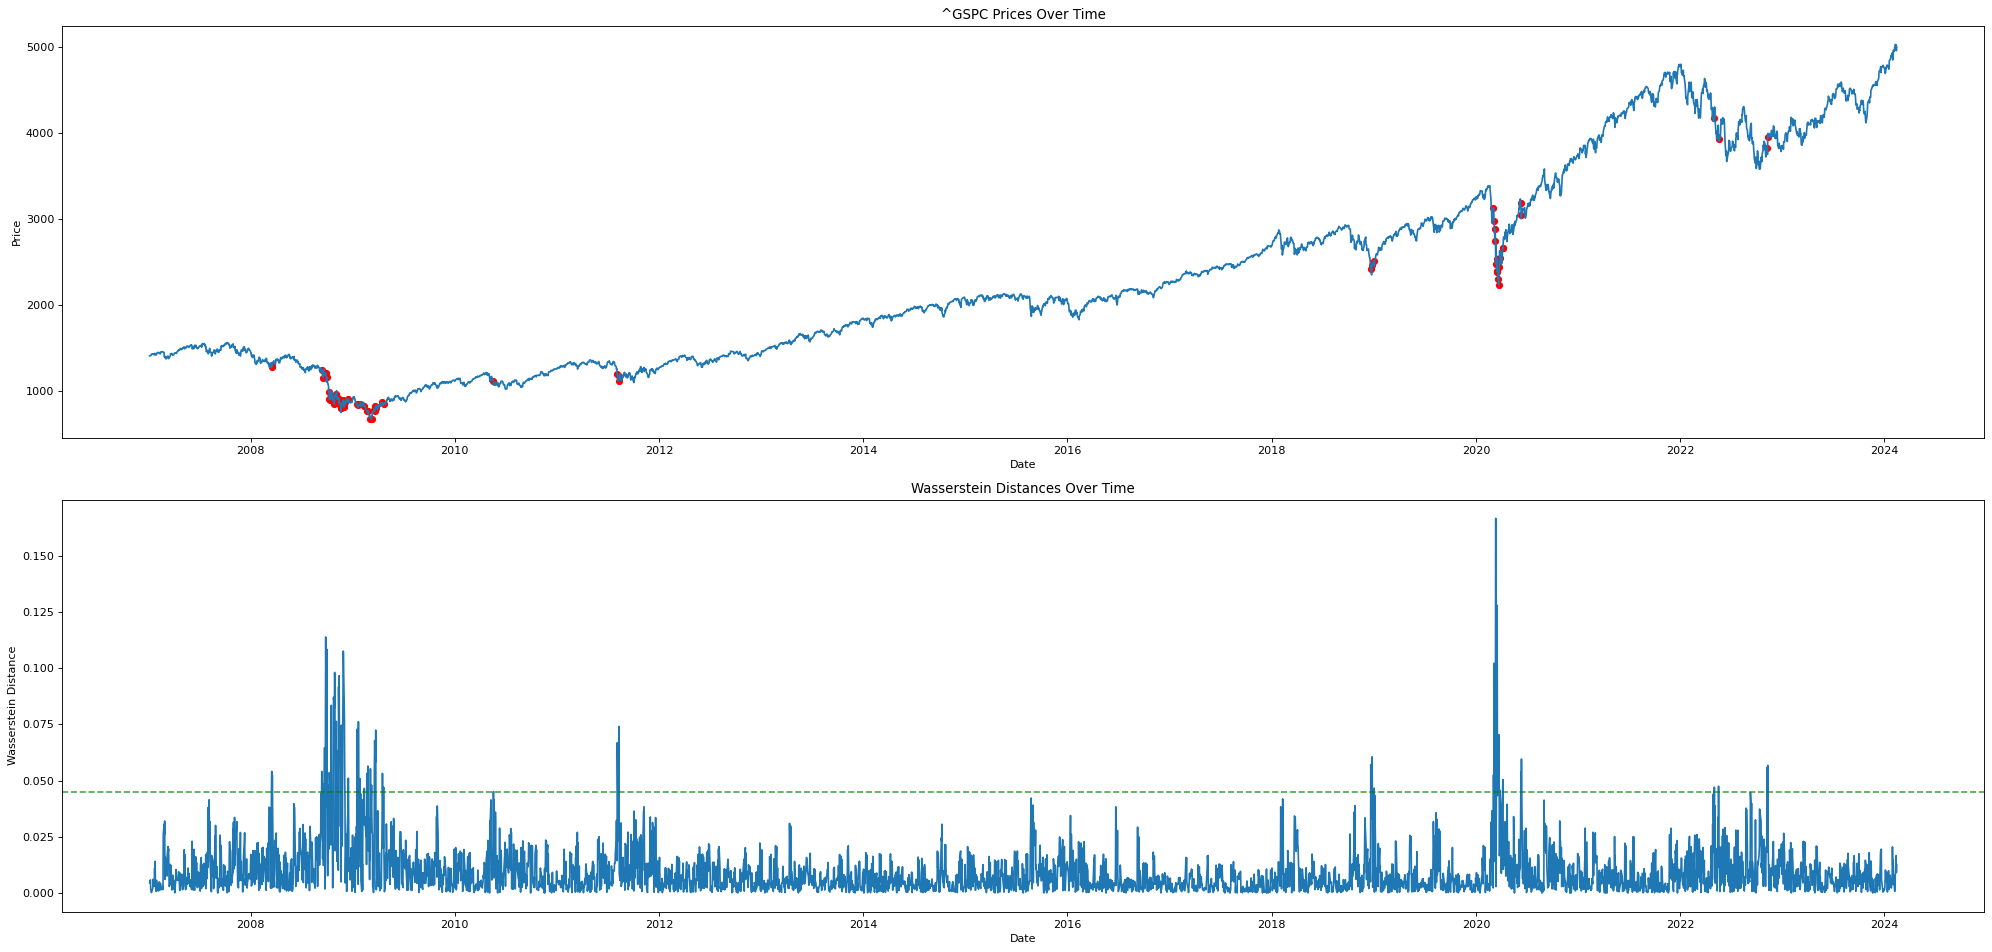

In [2]:
import yfinance as yf
import numpy as np
from ripser import Rips
import persim
import matplotlib.pyplot as plt
import warnings

def fetch_data(ticker_name, start_date, end_date):
    """Fetch stock data from Yahoo Finance."""
    raw_data = yf.download(ticker_name, start=start_date, end=end_date)
    adjusted_close = raw_data['Adj Close'].dropna()
    prices = adjusted_close.values
    log_returns = np.log(prices[1:] / prices[:-1])
    return adjusted_close, log_returns

def compute_wasserstein_distances(log_returns, window_size, rips):
    """Compute the Wasserstein distances."""
    n = len(log_returns) - (2 * window_size) + 1
    distances = np.full((n, 1), np.nan)  # Using np.full with NaN values
    for i in range(n):
        segment1 = log_returns[i:i+window_size].reshape(-1, 1)
        segment2 = log_returns[i+window_size:i+(2*window_size)].reshape(-1, 1)
        if segment1.shape[0] != window_size or segment2.shape[0] != window_size:
            continue
        dgm1 = rips.fit_transform(segment1)
        dgm2 = rips.fit_transform(segment2)
        distance = persim.wasserstein(dgm1[0], dgm2[0], matching=False)
        distances[i] = distance
    return distances

def plot_data(prices, distances, threshold, window_size):
    """Generate the plots."""
    dates = prices.index[window_size:-window_size]
    valid_indices = ~np.isnan(distances)
    valid_dates = dates[valid_indices.flatten()]
    valid_distances = distances[valid_indices]
    alert_indices = [i for i, d in enumerate(valid_distances) if d > threshold]
    alert_dates = [valid_dates[i] for i in alert_indices]
    alert_values = [prices.iloc[i + window_size] for i in alert_indices]
    fig, ax = plt.subplots(2, 1, figsize=(25, 12), dpi=80)
    ax[0].plot(valid_dates, prices.iloc[window_size:-window_size], label=ticker_name)
    ax[0].scatter(alert_dates, alert_values, color='r', s=30)
    ax[0].set_title(f'{ticker_name} Prices Over Time')
    ax[0].set_ylabel('Price')
    ax[0].set_xlabel('Date')
    ax[1].plot(valid_dates, valid_distances)
    ax[1].set_title('Wasserstein Distances Over Time')
    ax[1].set_ylabel('Wasserstein Distance')
    ax[1].axhline(threshold, color='g', linestyle='--', alpha=0.7)
    ax[1].set_xlabel('Date')
    plt.tight_layout()
    plt.show()

# Configuration
ticker_name = '^GSPC'  # SP500
start_date_string = "2007-01-01"
end_date_string = "2024-04-21"
window_size = 2
threshold = 0.045
warnings.filterwarnings('ignore')

prices, log_returns = fetch_data(ticker_name, start_date_string, end_date_string)
rips = Rips(maxdim=2)
wasserstein_dists = compute_wasserstein_distances(log_returns, window_size, rips)
plot_data(prices, wasserstein_dists, threshold, window_size)